In [1]:
import h5py
import numpy as np
import scipy.signal as signal
import pywt
import os


In [2]:
# === Đường dẫn file gộp và file đầu ra ===
input_path = r"D:\Python\data-ppg-ecg\cuff+less+blood+pressure+estimation\data_Test\ALL_PARTS_COMBINED.h5"
output_path = r"D:\Python\data-ppg-ecg\cuff+less+blood+pressure+estimation\data_Test\filtered_segments.h5"

# Đọc dữ liệu
with h5py.File(input_path, 'r') as f:
    print("📂 Dataset trong file:")
    f.visit(print)
    data = f['data'][:]  # Đảm bảo trong file có dataset 'data'
    ppg_raw = data[:, 0]
    abp_raw = data[:, 1]
    ecg_raw = data[:, 2]

fs = 125

📂 Dataset trong file:
data


ppg_segments_visualization.png


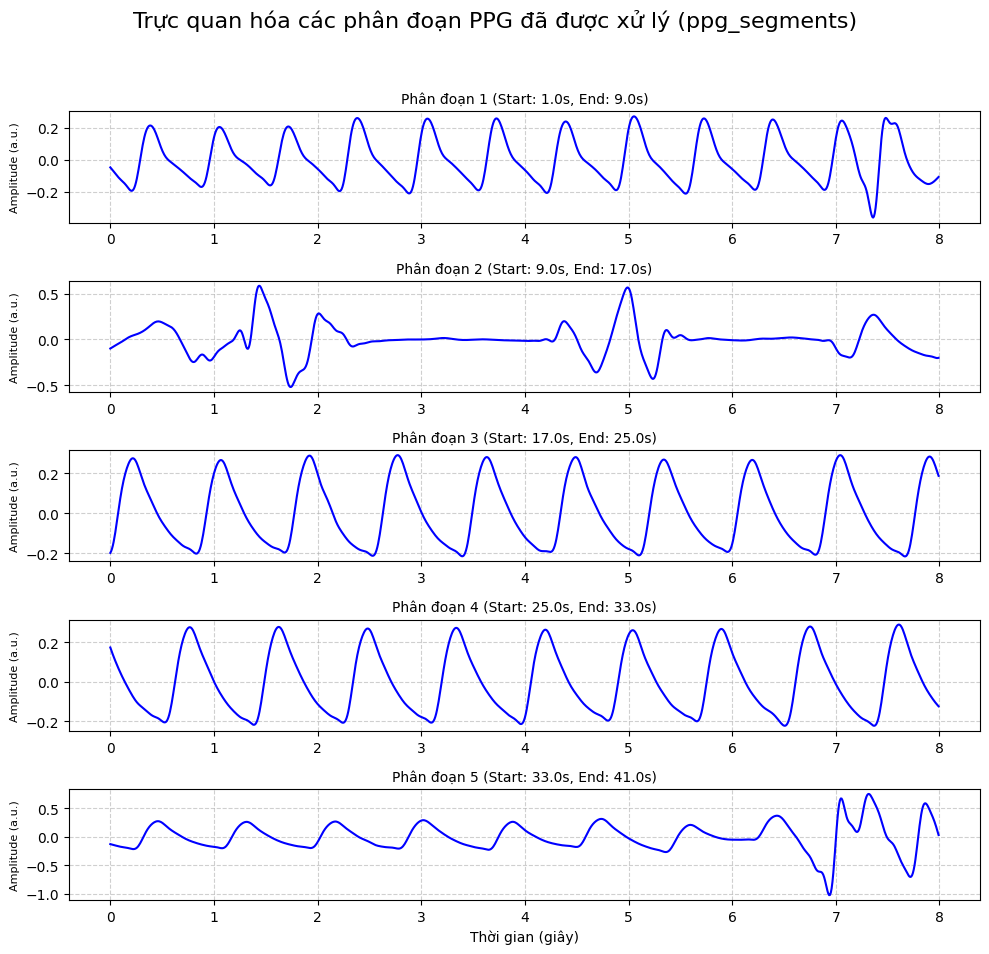

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- 1. GENERATE DUMMY DATA ---
fs = 125  # Sampling frequency (100 Hz)
duration = 60  # Total duration in seconds
time = np.arange(0, duration, 1/fs)


# Define segmentation indices (e.g., 5 segments of 5 seconds, skipping the ends)
segment_length = 8 * fs
idx = [
    (1*fs, 1*fs + segment_length),
    (9*fs, 9*fs + segment_length),
    (17*fs, 17*fs + segment_length),
    (25*fs, 25*fs + segment_length),
    (33*fs, 33*fs + segment_length)
]
# 5 segments of 10 seconds 🥳


# --- Tiền xử lý PPG ---
sos_ppg = signal.cheby2(4, 20, [0.5, 10], btype='bandpass', fs=fs, output='sos')
ppg_f = signal.sosfiltfilt(sos_ppg, ppg_raw)
x = np.arange(len(ppg_f))
trend = np.polyval(np.polyfit(x, ppg_f, 3), x)
ppg_f = ppg_f - trend
ppg_segments = [ppg_f[s:e] for s, e in idx]

# --- 3. PLOT VISUALIZATION ---
n_segments = len(ppg_segments)

# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('Trực quan hóa các phân đoạn PPG đã được xử lý (ppg_segments)', fontsize=16)

for i, segment in enumerate(ppg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.savefig('ppg_segments_visualization.png')
print("ppg_segments_visualization.png")

ecg_segments_visualization.png


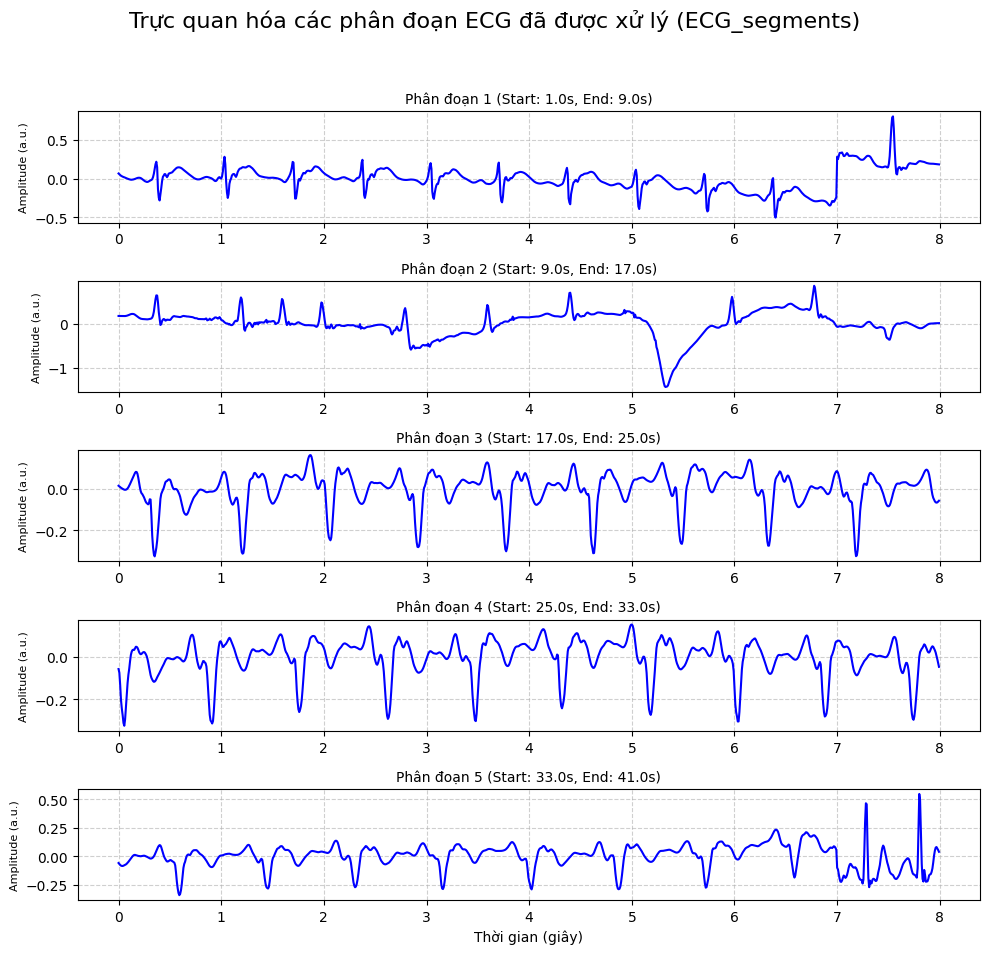

In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# --- 1. GENERATE DUMMY DATA ---
fs = 125  # Sampling frequency (100 Hz)
duration = 30  # Total duration in seconds
time = np.arange(0, duration, 1/fs)


# Define segmentation indices (e.g., 5 segments of 5 seconds, skipping the ends)
segment_length = 8 * fs
idx = [
    (1*fs, 1*fs + segment_length),
    (9*fs, 9*fs + segment_length),
    (17*fs, 17*fs + segment_length),
    (25*fs, 25*fs + segment_length),
    (33*fs, 33*fs + segment_length)
]


# --- Tiền xử lý ECG ---
sos_ecg = signal.butter(8, 0.1, btype='highpass', fs=fs, output='sos')
ecg_hp = signal.sosfiltfilt(sos_ecg, ecg_raw)
coeffs = pywt.wavedec(ecg_hp, 'db6', level=3, mode='symmetric')
sigma = np.median(np.abs(coeffs[-1]))/0.6745
thr = sigma*np.sqrt(2*np.log(len(ecg_hp)))
coeffs[1:] = [pywt.threshold(c, thr, mode='soft') for c in coeffs[1:]]
ecg_f = pywt.waverec(coeffs, 'db6', mode='symmetric')[:len(ecg_hp)]

ecg_segments = [ecg_f[s:e] for s, e in idx]


# --- 3. PLOT VISUALIZATION ---
n_segments = len(ecg_segments)

# Determine the layout for subplots (e.g., 5 segments -> 5x1 layout)
fig, axes = plt.subplots(n_segments, 1, figsize=(10, 2 * n_segments), sharex=False)
fig.suptitle('Trực quan hóa các phân đoạn ECG đã được xử lý (ECG_segments)', fontsize=16)

for i, segment in enumerate(ecg_segments):
    # Calculate time vector for the segment
    segment_time = np.arange(len(segment)) / fs
    
    # Plotting the segment
    ax = axes[i]
    ax.plot(segment_time, segment, color='b')
    ax.set_title(f'Phân đoạn {i+1} (Start: {idx[i][0]/fs:.1f}s, End: {idx[i][1]/fs:.1f}s)', fontsize=10)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Set common X-axis label for the bottom subplot
axes[-1].set_xlabel('Thời gian (giây)', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.savefig('ecg_segments_visualization.png')
print("ecg_segments_visualization.png")

In [6]:
# --- Tạo các đoạn tín hiệu cho PPG, ECG, ABP ---
ppg_segments = [ppg_f[s:e] for s, e in idx]
ecg_segments = [ecg_f[s:e] for s, e in idx]
abp_segments = [abp_raw[s:e] for s, e in idx]

In [7]:
labels = []
for abp_seg in abp_segments:
    # Tìm đỉnh tâm thu (SBP)
    peaks, _ = signal.find_peaks(abp_seg, distance=int(0.27*fs), prominence=np.std(abp_seg)*0.6)
    if len(peaks) < 2:
        labels.append([np.nan, np.nan, np.nan])
        continue
    sbps = abp_seg[peaks]
    dbps = []
    for i in range(len(peaks)-1):
        a, b = peaks[i], peaks[i+1]
        dbps.append(np.min(abp_seg[a:b]))
    SBP = float(np.mean(sbps))
    DBP = float(np.mean(dbps))
    HR = 60.0/np.mean(np.diff(peaks)/fs)
    labels.append([SBP, DBP, HR])
labels = np.array(labels)
print(labels)


[[103.61609355  52.46536548  94.17808219]
 [107.36272555  78.52440233  92.49743063]
 [100.43465913  55.12552485  70.25761124]
 [100.73887488  54.88106576  70.09345794]
 [117.34332882  58.09587885  72.73706897]]


In [8]:
# --- Lưu kết quả ---
with h5py.File(output_path, 'w') as f:
    f.create_dataset('ppg_segments', data=ppg_segments)
    f.create_dataset('ecg_segments', data=ecg_segments)
    f.create_dataset('labels', data=labels)
print(f"Đã lưu segment và nhãn sau tiền xử lý vào {output_path}")

Đã lưu segment và nhãn sau tiền xử lý vào D:\Python\data-ppg-ecg\cuff+less+blood+pressure+estimation\data_Test\filtered_segments.h5


after preprocess.png
after preprocess.png
after preprocess.png
after preprocess.png
after preprocess.png


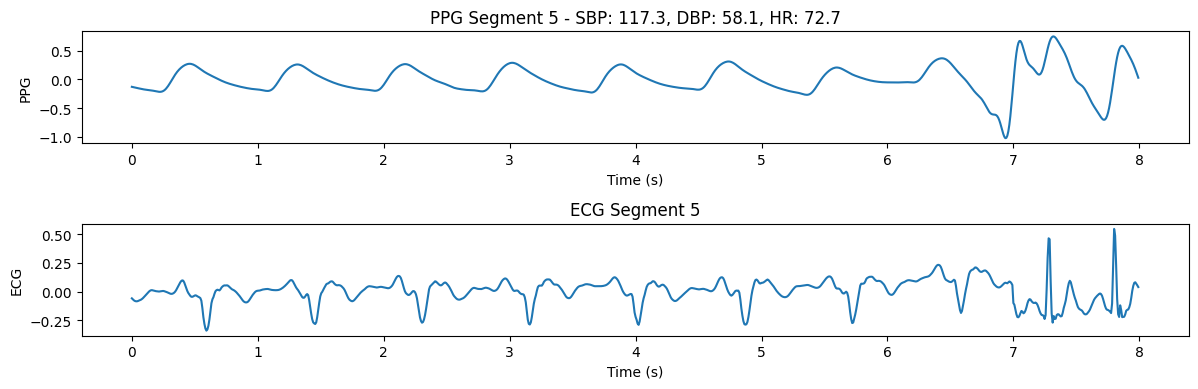

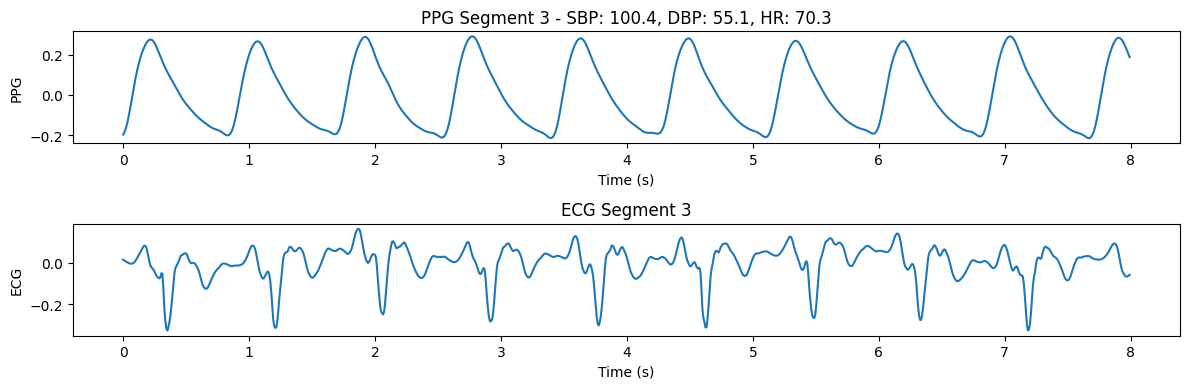

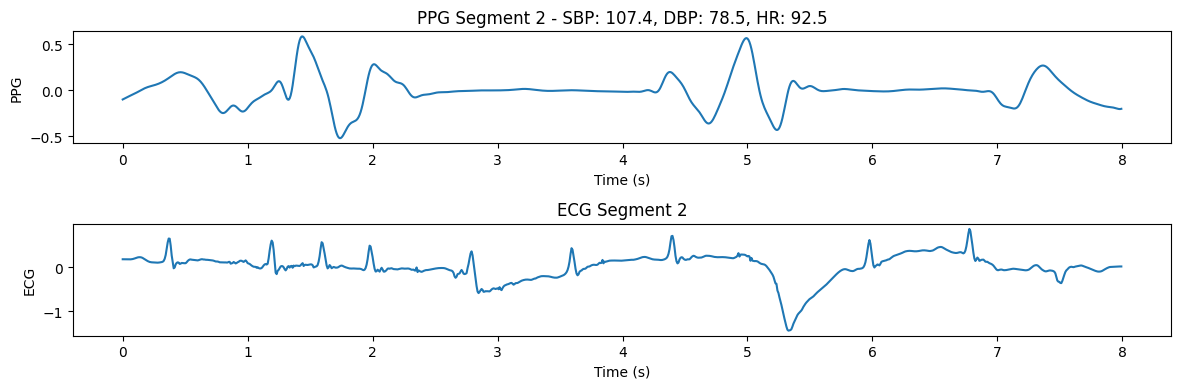

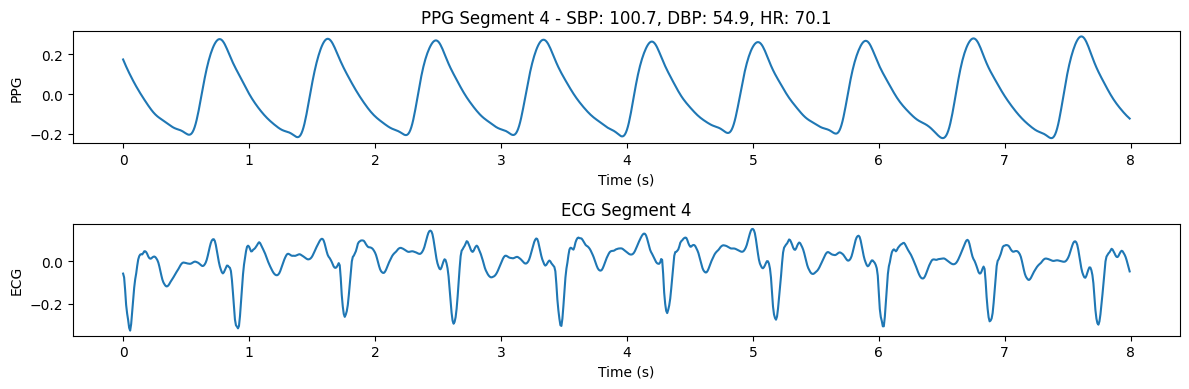

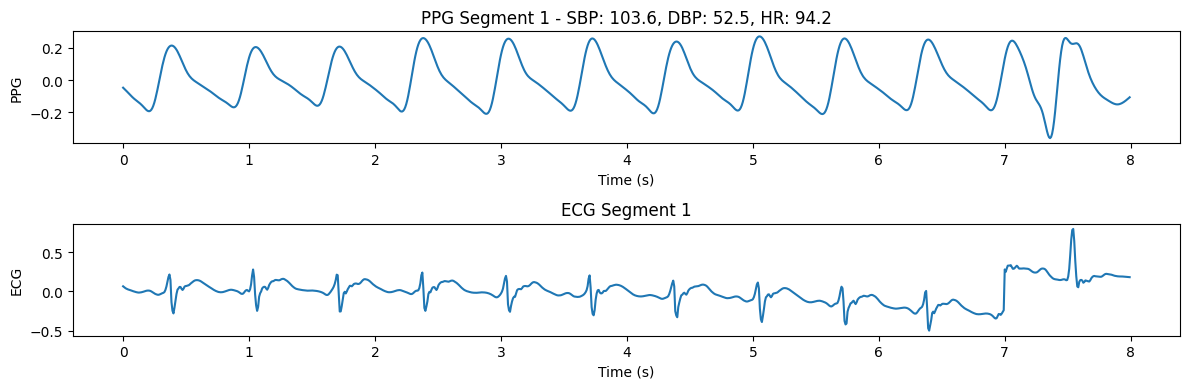

In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt


# Đường dẫn file đã xử lý
file_path = r"D:\Python\data-ppg-ecg\cuff+less+blood+pressure+estimation\data_Test\filtered_segments.h5"

with h5py.File(file_path, 'r') as f:
    ppg_segments = f['ppg_segments'][:]
    ecg_segments = f['ecg_segments'][:]
    labels = f['labels'][:]


N_PLOTS = 5 # Number of random segments to plot

# 1. Get a list of N_PLOTS random, unique indices
# (Assuming ppg_segments exists and has more than 5 rows)
try:
    N_TOTAL_SEGMENTS = ppg_segments.shape[0]
    random_indices = np.random.choice(N_TOTAL_SEGMENTS, size=N_PLOTS, replace=False)
except NameError:
    print("Please define 'ppg_segments' with your data to enable random plotting.")
    # Fallback to sequential plotting if data is not defined (for demonstration)
    random_indices = range(N_PLOTS)
# Vẽ thử 2 segment đầu tiên
fs = 125
for i in random_indices:
    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    plt.plot(np.arange(ppg_segments.shape[1])/fs, ppg_segments[i])
    plt.title(f"PPG Segment {i+1} - SBP: {labels[i,0]:.1f}, DBP: {labels[i,1]:.1f}, HR: {labels[i,2]:.1f}")
    plt.xlabel("Time (s)")
    plt.ylabel("PPG")
    plt.subplot(2,1,2)
    plt.plot(np.arange(ecg_segments.shape[1])/fs, ecg_segments[i])
    plt.title(f"ECG Segment {i+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("ECG")
    plt.tight_layout()
    plt.savefig("after preprocess{}.png".format(i))
    print("after preprocess.png")